# Data visualization - Breakdown by ASVs (Figure 3)

## Before you start

Run the accompanying shell script `fig3_preprocess.sh` found in this directory, which should run out-of-the-box.

That script is a re-implementation of the one found in `scripts/preprocess/agglomerate_asvs.sh`. Effectively, it will generate a collection of dataset pickle files -- essentially copies of ones used in the inference -- but with the first two timepoints `t=0, t=0.5` re-inserted.

In [1]:
# import statements
import mdsine2 as md2
import pandas as pd
import numpy as np
import argparse
import os

import matplotlib
from matplotlib import rcParams
from matplotlib import font_manager
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


#import matplotlib.font_manager
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.patches import Rectangle
from matplotlib.colors import LogNorm
from matplotlib import rcParams
from matplotlib import font_manager

[DEBUG] Using default logger (stdout, stderr).


In [80]:
# Plot configuration
rcParams['pdf.fonttype'] = 42
PERTURBATION_COLOR = "orange"
CUTOFF_FRAC_ABUNDANCE = 0.005  # Aggregation of abundances below this threhold

In [38]:
# Data files, to be generated by fig3_preprocess.sh shell script

data_dir = Path('./gibson_full_timepoints')
healthy_inoc_pkl = data_dir / 'healthy' / 'gibson_inoculum_agg_full_timepoints.pkl'
healthy_pkl = data_dir / 'healthy' / 'gibson_healthy_agg_full_timepoints.pkl'
uc_inoc_pkl = data_dir / 'uc' / 'gibson_inoculum_agg_full_timepoints.pkl'
uc_pkl = data_dir / 'uc' / 'gibson_uc_agg_full_timepoints.pkl'

print(healthy_inoc_pkl.exists())
print(healthy_pkl.exists())
print(uc_inoc_pkl.exists())
print(uc_pkl.exists())
if not healthy_inoc_pkl.exists() or not healthy_pkl.exists() or not uc_inoc_pkl.exists() or not uc_pkl.exists():
    print("Run the accompanying shell script first.")
else:
    subjset_healthy = md2.Study.load(healthy_pkl)
    subjset_healthy_inoc = md2.Study.load(healthy_inoc_pkl)
    subjset_uc = md2.Study.load(uc_pkl)
    subjset_uc_inoc = md2.Study.load(uc_inoc_pkl)

True
True
True
True


# Experiment timeline.

In [5]:
def draw_experiment(ax, subjset):
    """render figure illustrating the experiment"""
    times = []
    for subj in subjset:
        times = np.append(times, subj.times)
    times = np.sort(np.unique(times))

    y = [-0.1 for t in times]
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.xaxis.set_minor_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_minor_locator(plt.NullLocator())

    markerline, stemlines, baseline = ax.stem(times, y, linefmt='none')
    baseline.set_color('black')
    markerline.set_color('black')
    markerline.set_markersize(5)

    x = np.arange(0, np.max(times), step=10)
    labels = ['Day {}'.format(int(t)) for t in x]

    for ylim in [0.15, -0.35]:
        y = [ylim for t in x]
        markerline, stemlines, baseline = ax.stem(x, y)
        stemlines.set_color("black")
        baseline.set_color('black')
        markerline.set_color('none')
    for i in range(len(labels)):
        label = labels[i]
        xpos = x[i]
        ax.text(xpos, 0.-.6, label, horizontalalignment='center', fontsize=26)
    x = np.arange(0,np.max(times),2)
    for ylim in [0.07, -0.07]:
        y = [ylim for t in x]
        markerline, stemlines, baseline = ax.stem(x, y)
        stemlines.set_color("black")
        baseline.set_color('black')
        markerline.set_color('none')
    subj_ = None
    for subj in subjset:
        subj_ = subj
        break

    times_li = list(times)

    for perturbation in subjset.perturbations:
        name = perturbation.name
        x = (perturbation.ends[subj_.name] + perturbation.starts[subj_.name])/2
        ax.text(
            x, 0.25, name.capitalize(), 
            horizontalalignment='center', fontsize = 26
        )
        starts = np.asarray([perturbation.starts[subj_.name]])
        ends = np.asarray([perturbation.ends[subj_.name]])
        ax.barh(
            y=[0 for i in range(len(starts))], width=ends-starts, height=0.1,
            left=starts, color='darkgrey'
        )

    xpos = np.max(times)* 1.02
    y = 0.05
    ax.scatter([xpos], [y], c = 'black', s=26)
    ax.text(
        xpos+0.5, y, 'Fecal Sample Collection', horizontalalignment='left',
        fontsize = 26, verticalalignment='center'
    )

## Healthy

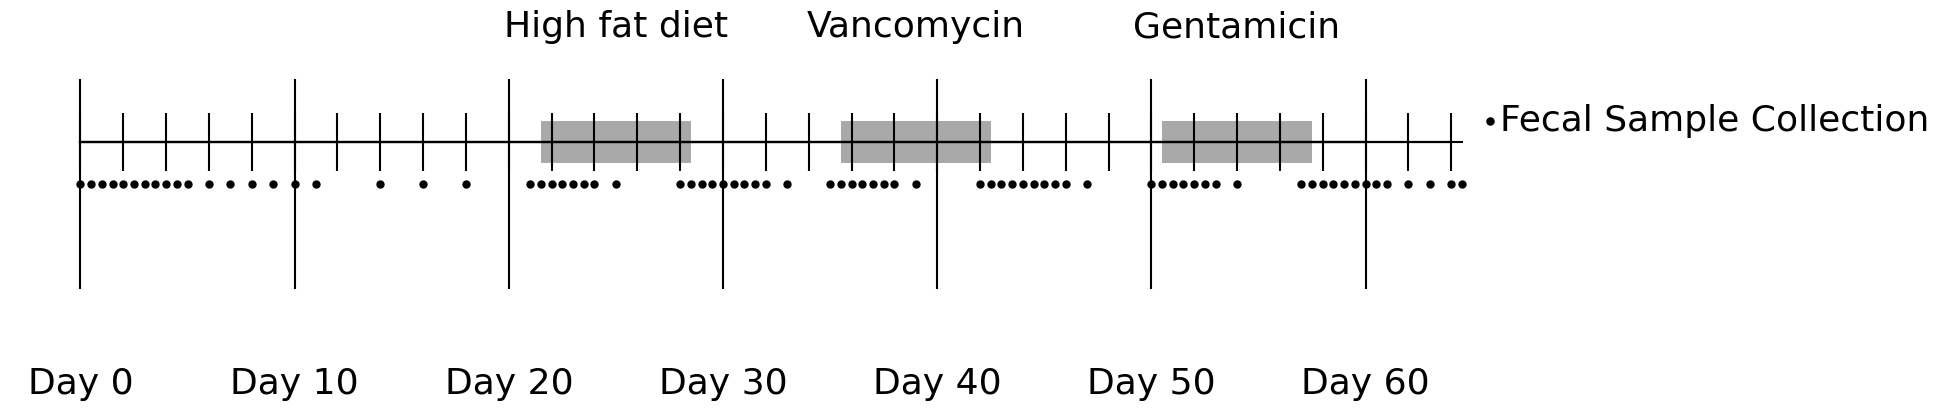

In [39]:
fig, ax = plt.subplots(figsize=(20, 3))
draw_experiment(ax, subjset_healthy)

## UC

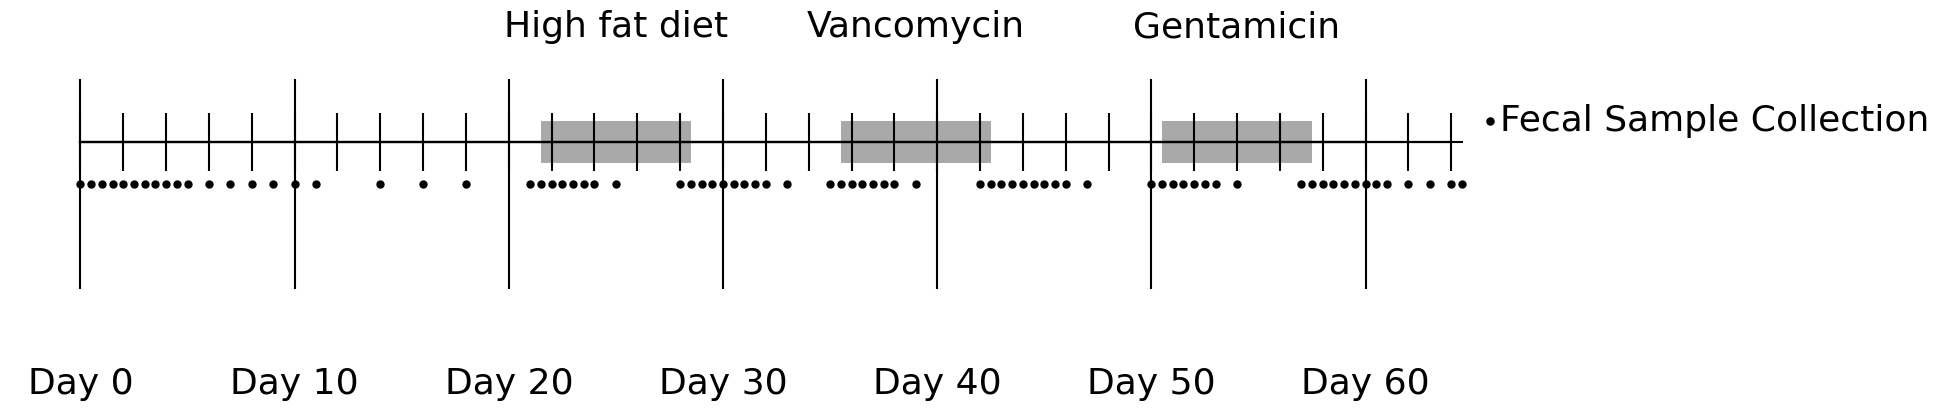

In [40]:
fig, ax = plt.subplots(figsize=(20, 3))
draw_experiment(ax, subjset_uc)

# Taxa abundance plot

## Helper Functions

In [42]:
# Function for extracting relevant taxa and abundances

def relabund_df_aggregated(subjset, data_mode='abs'):
    subjset.taxa.generate_consensus_taxonomies()
    tax_df = subjset_healthy.taxa.write_taxonomy_to_csv().set_index('name')
    abund_dfs = []
    for subj in subjset:
        abund_df = subj.df()[data_mode]
        times = abund_df.columns
        abund_dfs.append(
            abund_df.merge(
                tax_df, left_index=True, right_index=True
            ).groupby(
                ['order', 'family']
            )[times].sum()
        )

    cumulative_df = abund_dfs[0]
    for df in abund_dfs[1:]:
        cumulative_df = cumulative_df.add(df, axis='columns', fill_value=0)
    relabund_df = cumulative_df / cumulative_df.sum()
    return relabund_df


def filter_taxa(relabund_df):
    # Only keep taxa that have relabund mean exceeding threshold.
    to_keep = relabund_df.loc[relabund_df.mean(axis=1) > CUTOFF_FRAC_ABUNDANCE]
    to_remove = relabund_df.loc[relabund_df.mean(axis=1) <= CUTOFF_FRAC_ABUNDANCE]
    to_keep = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    return to_keep.index, to_remove.index


In [43]:
# Plotting code.

def geom_mean(x):
    return np.exp(np.log(x).mean())


def plot_qpcr(subjset, ax):
    #plot the absolute abundance
    qpcr_meas = {}
    for subj in subjset:
        for t in subj.times:
            if t not in qpcr_meas:
                qpcr_meas[t] = []
            qpcr_meas[t].append(subj.qpcr[t].mean())

    qpcr_meas = { t: geom_mean(vals) for t, vals in qpcr_meas.items() }
    times_qpcr = np.sort(list(qpcr_meas.keys()))
    qpcr_vals = [ qpcr_meas[t] for t in times_qpcr ]
    
    ax.plot(
        np.arange(0, len(times_qpcr)) + 0.5, 
        qpcr_vals, 
        marker='o', 
        linestyle='-',
        color='black'
    )
    ax.set_yscale('log')
    ax.set_ylabel('CFUs/g')

    max_qpcr_value = np.max(qpcr_vals)
    ax.set_ylim(bottom = 1e9, top = max_qpcr_value * (1.25))
    ax.set_yticks([1e10, 1e11])


def plot_relabund(relabund_df, to_keep, to_remove, ax, palette):
    """
    Plot the relative abundances as a stacked bar chart.
    """
    # Only plot the OTUs that have mean relabund exceeding threshold.
    to_keep = relabund_df.loc[to_keep]
    to_remove = relabund_df.loc[to_remove]
    
    relabund_df = to_keep.assign(
        Avg=np.mean(to_keep.values, axis=1)
    ).sort_values('Avg', ascending=False).drop(columns=['Avg'])
    relabund_df.loc[('Other', 'Other'), :] = to_remove.sum().values

    # Do the plotting.
    num_t = relabund_df.shape[1]
    num_r = relabund_df.shape[0]

    bottom = np.zeros(num_t)
    for (order, family), row in relabund_df.iloc[::-1].iterrows():
        ax.bar(
            np.arange(0, num_t),
            row.values,
            bottom=bottom,
            label=f'{order} {family}',
            color=palette[f'{order} {family}'],
            width=1.0,
            
        )
        bottom += row.values

    times = np.asarray(list(relabund_df.columns))
    xlocs = np.arange(0, len(times), step = 10)
    ax.set_xticks(xlocs)
    ax.set_xticklabels(times[xlocs])
    ax.set_ylim([0, 1])
    ax.set_xlim([-0.5, 0.5 + num_t - 1])

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5))
    

def add_perturbation_annotation(
    perturbations,
    target_subj,
    ax,
    pert_fill_alpha: float = 0.3,
    show_label: bool = False
):
    times = np.array(target_subj.times)
    if perturbations is None or len(perturbations) == 0:
        return
    
    subj = target_subj.name
    for pidx, perturbation in enumerate(perturbations):
        if subj not in perturbation.starts or subj not in perturbation.ends:
            continue

        start = perturbation.starts[subj]
        end = perturbation.ends[subj]
        if pert_fill_alpha > 0.0:
            ax.axvspan(
                xmin=start,
                xmax=end,
                facecolor=PERTURBATION_COLOR,
                alpha=pert_fill_alpha, 
                zorder=-10000
            )
        ax.axvline(x=start, color='black', linestyle='--', lw=2)
        ax.axvline(x=end, color='black', linestyle='--', lw=2)

        if show_label:
            import matplotlib.transforms as transforms
            trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)        
            ax.text(np.mean([start, end]), 1.0, perturbation.name, horizontalalignment='center', verticalalignment='bottom', transform=trans, fontsize=12)

## Determine what taxa to plot. And determine color palette.

In [86]:
# ===== Healthy
# Get the relative abundances over time.
healthy_relabund_df = relabund_df_aggregated(subjset_healthy, data_mode='abs')
healthy_to_keep, healthy_to_remove = filter_taxa(healthy_relabund_df)

# Print result.
print("Taxa to plot (ORDER, FAMILY):\n")
for order, family in healthy_to_keep:
    print(f'{order}, {family}')

Taxa to plot (ORDER, FAMILY):

Bacteroidales, Bacteroidaceae
Verrucomicrobiales, Akkermansiaceae
Bacteroidales, Porphyromonadaceae
Clostridiales, Lachnospiraceae
Burkholderiales, Sutterellaceae
Enterobacterales, Enterobacteriaceae
Acidaminococcales, Acidaminococcaceae
Bacteroidales, Prevotellaceae
Desulfovibrionales, Desulfovibrionaceae
Erysipelotrichales, Erysipelotrichaceae
Clostridiales, Ruminococcaceae
Clostridiales, Clostridiaceae_1
Bacteroidales, Rikenellaceae
Clostridiales, Peptostreptococcaceae
Bacteroidales, Barnesiellaceae


In [87]:
# ===== UC
# Get the relative abundances over time.
uc_relabund_df = relabund_df_aggregated(subjset_uc, data_mode='abs')
uc_to_keep, uc_to_remove = filter_taxa(uc_relabund_df)

# Print result.
print("Taxa to plot (ORDER, FAMILY):\n")
for order, family in uc_to_keep:
    print(f'{order}, {family}')

Taxa to plot (ORDER, FAMILY):

Bacteroidales, Bacteroidaceae
Verrucomicrobiales, Akkermansiaceae
Clostridiales, Lachnospiraceae
Bacteroidales, Porphyromonadaceae
Enterobacterales, Enterobacteriaceae
Burkholderiales, Sutterellaceae
Clostridiales, Ruminococcaceae
Bacteroidales, Rikenellaceae
Clostridiales, Clostridiaceae_1
Erysipelotrichales, Erysipelotrichaceae


In [83]:
# This also decides the color palette.
colors = np.concatenate([sns.color_palette('muted', n_colors=20), sns.color_palette("dark", n_colors=20)])
palette = {}
i = 0
for order, family in list(healthy_to_keep) + list(uc_to_keep):
    taxa_key = f'{order} {family}'
    if taxa_key in palette:
        continue
    else:
        palette[taxa_key] = colors[i]
        i += 1
palette['Other Other'] = colors[i+1]

## Healthy

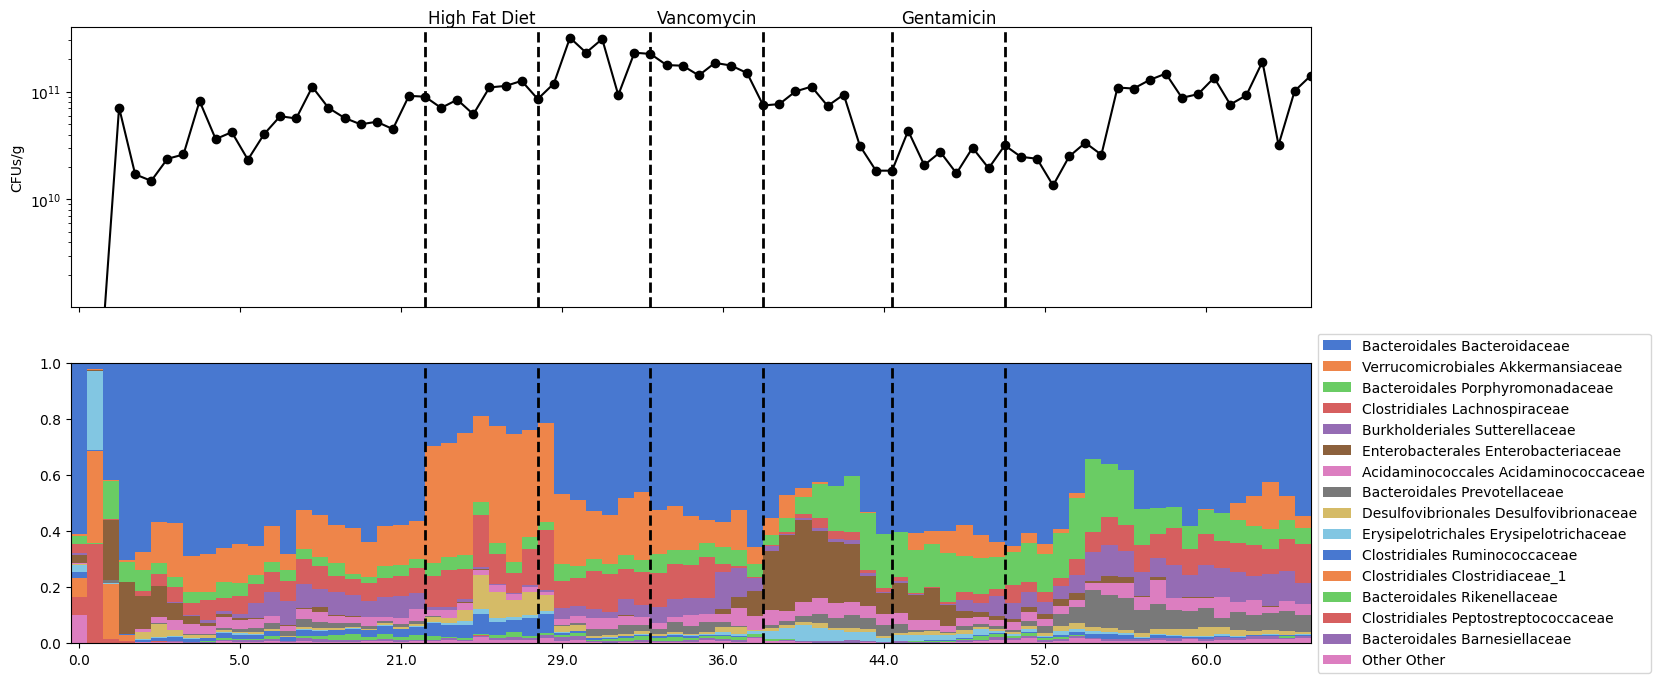

In [84]:
# Render plots.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plot_qpcr(subjset_healthy, ax=ax[0])
plot_relabund(healthy_relabund_df, healthy_to_keep, healthy_to_remove, ax=ax[1], palette=palette)

# Plot.
add_perturbation_annotation(subjset_healthy.perturbations, subjset_healthy['2'], ax[0], pert_fill_alpha=0.0, show_label=True)
add_perturbation_annotation(subjset_healthy.perturbations, subjset_healthy['2'], ax[1], pert_fill_alpha=0.0, show_label=False)

## UC

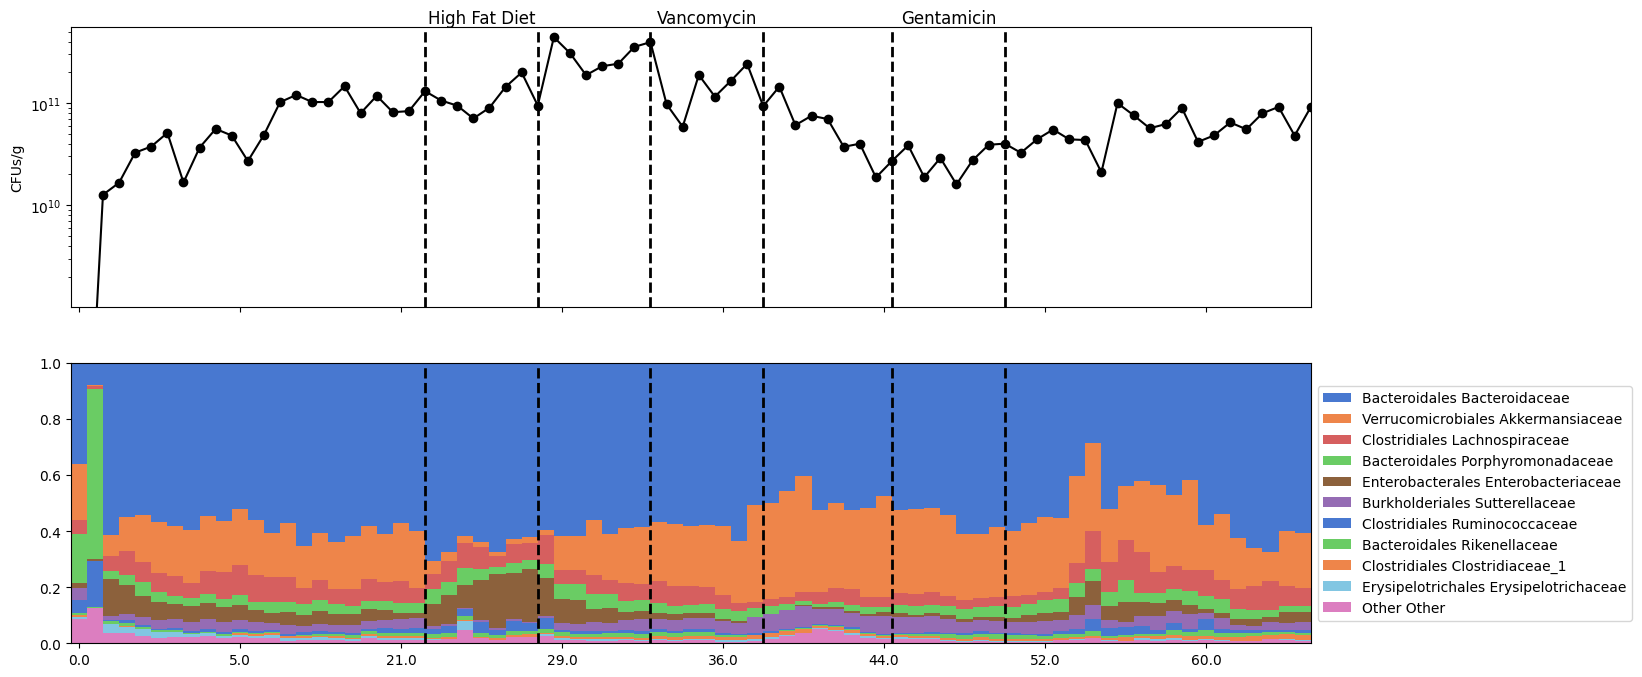

In [85]:
# Render plots.
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(16, 8))
plot_qpcr(subjset_uc, ax=ax[0])
plot_relabund(uc_relabund_df, uc_to_keep, uc_to_remove, ax=ax[1], palette=palette)

# Plot.
add_perturbation_annotation(subjset_uc.perturbations, subjset_uc['6'], ax[0], pert_fill_alpha=0.0, show_label=True)
add_perturbation_annotation(subjset_uc.perturbations, subjset_uc['6'], ax[1], pert_fill_alpha=0.0, show_label=False)

# Relative abundances at family level, for inoculum

## Healthy inoculum

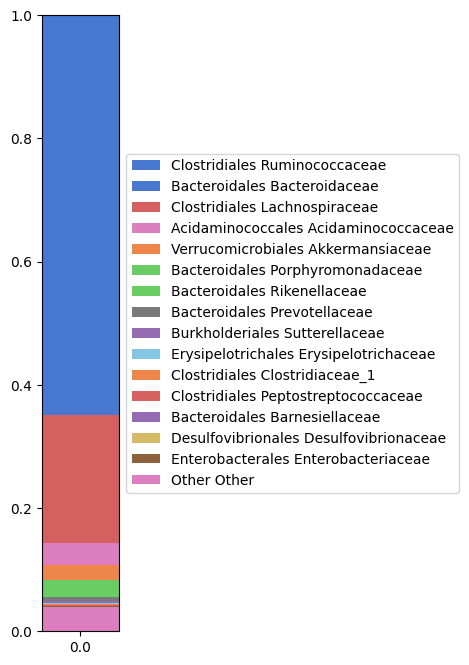

In [88]:
fig, ax = plt.subplots(1, 1, figsize=(1, 8))

inoc_healthy_relabund_df = relabund_df_aggregated(subjset_healthy_inoc, data_mode='raw')
plot_relabund(inoc_healthy_relabund_df, healthy_to_keep, healthy_to_remove, ax=ax, palette=palette)

## UC inoculum

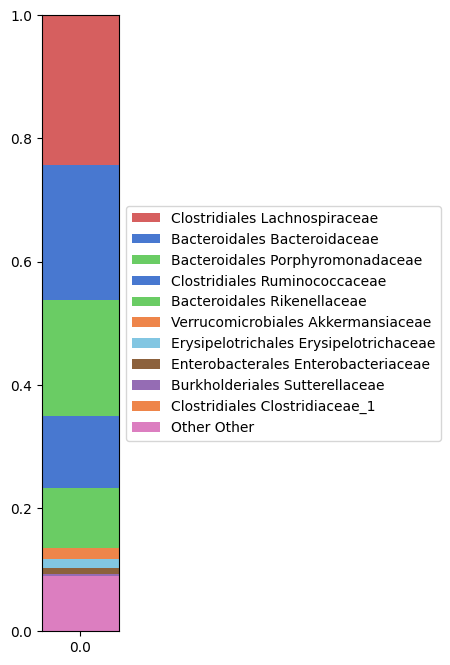

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(1, 8))

inoc_uc_relabund_df = relabund_df_aggregated(subjset_uc_inoc, data_mode='raw')
plot_relabund(inoc_uc_relabund_df, uc_to_keep, uc_to_remove, ax=ax, palette=palette)

# Relative abundance of the top 100 abundant taxa.

In [14]:
# Some code for plotting

def next_biggest(target, array):
    """implemements a binary search to find the first position of the item
        in the array that is greater than or equal to target"""

    start = 0
    end = len(array) - 1
    ans = -1
    while start <= end:
        mid = (start+end)//2
        if array[mid] < target:
            start = mid + 1
        else:
            ans = mid
            end = mid - 1

    return ans
    

def rel_abundance_plot(subject, ax, n, t):
    """plots the relative abundances of top n bugs at time t"""

    try:
        abund_series = subject.df()["rel"][t]
        names = [taxon.name for taxon in subject.taxa]
        abund_series.index = names
        abund_series = abund_series.sort_values(ascending=False).head(100)

        abund_df = abund_series.to_frame().reset_index()
        abund_df.columns = ["otu_names", "abundance"]

        axis = sns.barplot(y="abundance", x="otu_names", data=abund_df,
            color="tab:grey")
        axis.set_xlabel("Top 100 most abundant OTUs", size=18, fontweight="bold")
        #axis.set_xlabel("")
        axis.set_ylabel("Relative Abundace", size=18, fontweight="bold")
        axis.ticklabel_format(axis="y", style="sci")
        axis.set_ylim(1e-5, 0.5)
        axis.set_yscale("log")
        axis.set_yticks([1e-4, 1e-3, 1e-2, 1e-1])
        axis.set_yticklabels(axis.get_yticks(), fontsize=15, rotation=0)


        np_abundance = abund_df["abundance"].to_numpy()
        cdf = [np_abundance[0]]
        for i in range(1, np_abundance.shape[0]):
            cdf.append(cdf[i-1] + np_abundance[i])
        cdf = np.asarray(cdf)

        pos_50 = next_biggest(0.55, cdf)
        pos_90 = next_biggest(0.90, cdf)
        pos_99 = next_biggest(0.99, cdf)
        pos_999 = next_biggest(0.999, cdf)
        pos_9999 = next_biggest(0.9999, cdf)

        new_xticks = [pos_50, pos_90, pos_99, pos_999, pos_9999]
        new_xticks = [x + 0.5 for x in new_xticks if x != -1]
        tick_labels = ["50%", "90%", "99%", "99.9%", "99.99%"]
        tick_labels = tick_labels[:len(new_xticks)]

        otu_arr = abund_df["otu_names"].to_numpy()
        
        axis.set_xticks(new_xticks)
        axis.set_xticklabels(tick_labels, fontsize=15)
        
        for x in new_xticks:
            axis.axvline(x=x, color="black", linestyle="--")

        abund_df["cdf"] = cdf
    except KeyError:
        print("No data available for time point {}. Please select a valid"\
            "time point".format(t))

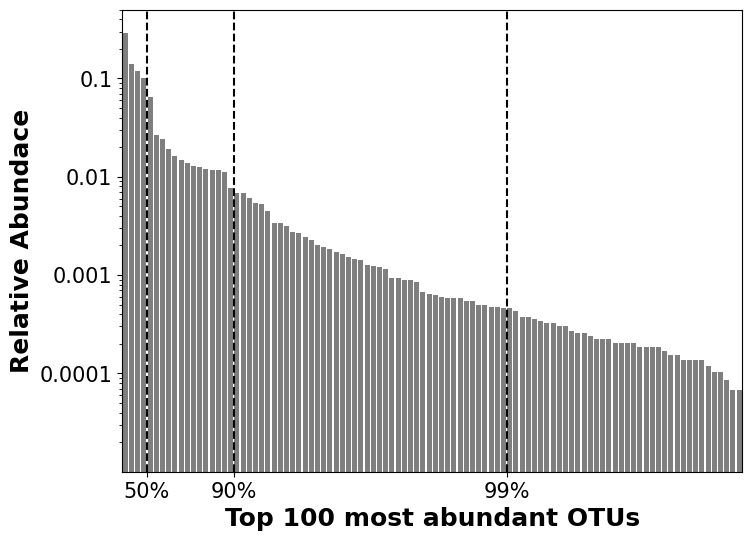

In [15]:
# Draw the plot.
fig, ax = plt.subplots(figsize=(8, 6))
rel_abundance_plot(subjset_healthy['2'], ax, n=100, t=10.0)

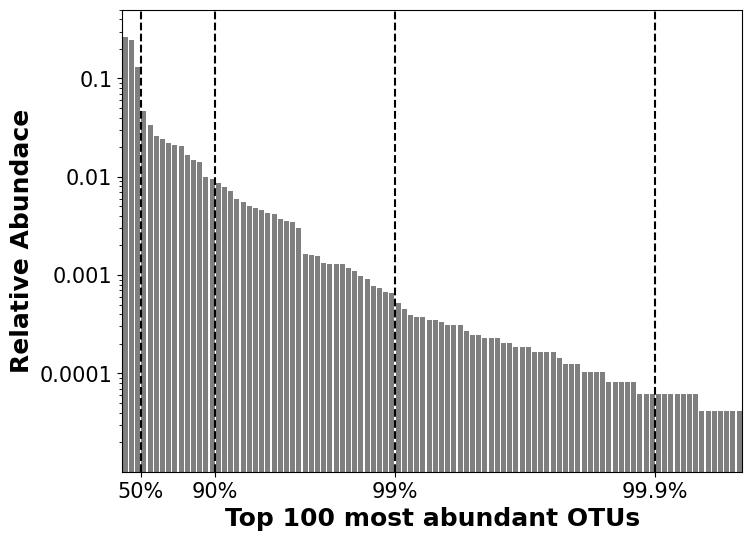

In [69]:
# Draw the plot.
fig, ax = plt.subplots(figsize=(8, 6))
rel_abundance_plot(subjset_uc['6'], ax, n=100, t=10.0)